### 1: Import required packages & functions <a class="anchor" id="chapter1"></a>

In [1]:
# clear all variables
for i in list(globals().keys()):
    if(i[0] != '_'):
        exec('del {}'.format(i))

#suppress future warnings -- not really a good idea 
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
        
# suppress future warnings -- not really a good idea 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# ignore all warnings
import warnings
warnings.filterwarnings('ignore')


# import required dependencies
import os
import numpy as np 
import pandas as pd 
import seaborn as sns
from keras.models import Model
from keras.layers import Input, Dense
from numpy.random import seed
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, silhouette_score
import csv
import xlrd
import math
from matplotlib import figure
from IPython.display import FileLink, FileLinks
from IPython.display import set_matplotlib_formats

#import utils
#from utils import encode_features_v3

set_matplotlib_formats('png', 'pdf') # uses vector figures in pdf exports --
plt.style.use('seaborn-pastel')

# create a folder
def create_folder(folder):
    import os     
    try: 
        os.mkdir(folder) 
    except FileExistsError:
        print("Directory [ %s ] already exists"%folder)
        
#create folder to store results
create_folder('CFAS and ADNI')
create_folder('CFAS and ADNI/data')
create_folder('CFAS and ADNI/figure')
create_folder('Ranking')

Directory [ CFAS and ADNI ] already exists
Directory [ CFAS and ADNI/data ] already exists
Directory [ CFAS and ADNI/figure ] already exists
Directory [ Ranking ] already exists


## 2. Loading data obtained from Weka and Scale all Weights <a class="anchor" id="chapter2"></a>

#### Extracting features names and filter methods weights and Scaling all filter methods weights

In [5]:
# load all filter methods scores obtained from weka
cfas_weka = pd.read_excel('Dataset/WEKA/cfas_Remove(MCI)_no_demo.xlsx', header = 0) 
adni_weka = pd.read_excel('Dataset/WEKA/adni_Remove(MCI)_no_demo.xlsx', header = 0) 

def extraction(method, method_name):
    df = pd.DataFrame(columns=['Features', method_name])
    for line in method:
        line_list = line.split()
        weight = line_list[0]
        feature = ' '.join(line_list[2:len(line_list)])

        df = df.append({'Features':str(np.squeeze(feature)), method_name:float(np.squeeze(weight))}, ignore_index=True)
    df = df.sort_values('Features',ascending=True, key=lambda x: x.str.lower())
    df.reset_index(drop=True, inplace=True)
    return df


excel = pd.DataFrame(cfas_weka).copy()
cfas_values = pd.DataFrame(extraction(excel['Chi-Squares'], 'Chi-Squares'))
gr = extraction(excel['Gain Ratio'], 'Gain Ratio')
cfas_values['Gain Ratio'] = gr['Gain Ratio']
ig = extraction(excel['Information Gain'], 'Information Gain')
cfas_values['Information Gain'] = ig['Information Gain']
rf = extraction(excel['ReliefF'], 'ReliefF')
cfas_values['ReliefF'] = rf['ReliefF']
su = extraction(excel['Symmetrical Uncertainty'], 'Symmetrical Uncertainty')
cfas_values['Symmetrical Uncertainty'] = su['Symmetrical Uncertainty']
ll = extraction(excel['Least Loss'], 'Least Loss')
cfas_values['Least Loss'] = ll['Least Loss']
va = extraction(excel['Va'], 'Va')
cfas_values['Va'] = va['Va']
cfas_values
cfas_values.to_csv(r'Ranking/cfas_values.csv',index=False)
cfas_values

excel = pd.DataFrame(adni_weka).copy()
adni_values = pd.DataFrame(extraction(excel['Chi-Squares'], 'Chi-Squares'))
gr = extraction(excel['Gain Ratio'], 'Gain Ratio')
adni_values['Gain Ratio'] = gr['Gain Ratio']
ig = extraction(excel['Information Gain'], 'Information Gain')
adni_values['Information Gain'] = ig['Information Gain']
rf = extraction(excel['ReliefF'], 'ReliefF')
adni_values['ReliefF'] = rf['ReliefF']
su = extraction(excel['Symmetrical Uncertainty'], 'Symmetrical Uncertainty')
adni_values['Symmetrical Uncertainty'] = su['Symmetrical Uncertainty']
ll = extraction(excel['Least Loss'], 'Least Loss')
adni_values['Least Loss'] = ll['Least Loss']
va = extraction(excel['Va'], 'Va')
adni_values['Va'] = va['Va']

adni_values.to_csv(r'Ranking/adni_values.csv',index=False)


In [6]:
from sklearn.preprocessing import MinMaxScaler

# load all filter methods scores obtained from weka
cfas_weka_results = pd.read_excel('Dataset/WEKA/cfas_weka_Binary_Remove(MCI)_plaqsc_no_demographics_2.xlsx', header = 0) 
adni_weka_results = pd.read_excel('Dataset/WEKA/adni_weka_Binary_Remove(MCI)_no_demographics_2.xlsx', header = 0) 

#Extracting all feature names
cfas_feature_names = cfas_weka_results[['Features']].copy()
adni_feature_names = adni_weka_results[['Features']].copy()

#extracting all filters mathods values 
cfas_filters_wieghts = cfas_weka_results[['Chi-Squares', 'Gain Ratio', 'Information Gain', 'ReliefF', 'Symmetrical Uncertainty', 'Least Loss', 'Va']].copy()
adni_filters_wieghts = adni_weka_results[['Chi-Squares', 'Gain Ratio', 'Information Gain', 'ReliefF', 'Symmetrical Uncertainty', 'Least Loss', 'Va']].copy()


#Extracting all feature names
cfas_feature_names = cfas_values[['Features']].copy()
adni_feature_names = adni_values[['Features']].copy()

#extracting all filters mathods values 
cfas_filters_wieghts = cfas_values[['Chi-Squares', 'Gain Ratio', 'Information Gain', 'ReliefF', 'Symmetrical Uncertainty', 'Least Loss', 'Va']].copy()
adni_filters_wieghts = adni_values[['Chi-Squares', 'Gain Ratio', 'Information Gain', 'ReliefF', 'Symmetrical Uncertainty', 'Least Loss', 'Va']].copy()
adni_filters_wieghts


#Scale all filter methods scores
cfas_scaler = MinMaxScaler()
cfas_scaled = cfas_scaler.fit_transform(cfas_filters_wieghts)
adni_scaler = MinMaxScaler()
adni_scaled = adni_scaler.fit_transform(adni_filters_wieghts)

cfas_scaled_dataset = pd.DataFrame({'Chi2': cfas_scaled[:, 0], 'GainRatio': cfas_scaled[:, 1],
                                    'InfoGain': cfas_scaled[:, 2], 'Relieff': cfas_scaled[:, 3],
                                    'Symmetrical': cfas_scaled[:, 4], 'LeastLoss': cfas_scaled[:, 5],
                                    'Va': cfas_scaled[:, 6]})
adni_scaled_dataset = pd.DataFrame({'Chi2': adni_scaled[:, 0], 'GainRatio': adni_scaled[:, 1],
                                    'InfoGain': adni_scaled[:, 2], 'Relieff': adni_scaled[:, 3],
                                    'Symmetrical': adni_scaled[:, 4], 'LeastLoss': adni_scaled[:, 5],
                                    'Va': adni_scaled[:, 6]})

#create folder to store results
create_folder('Ranking')
cfas_scaled_dataset.to_csv(r'Ranking/cfas_scaled_dataset.csv',index=False)
adni_scaled_dataset.to_csv(r'Ranking/adni_scaled_dataset.csv',index=False)


Directory [ Ranking ] already exists


## 3. Processing scaled data to get the average <a class="anchor" id="chapter4"></a>

### CFAS Averaging

In [7]:
#Find the sum of each filter method using all samples
cfas_scaled_columns_sum = pd.DataFrame()
cfas_scaled_columns_sum['Sum'] = np.around(cfas_scaled_dataset.sum(axis=0),2)
cfas_scaled_columns_sum = cfas_scaled_columns_sum.T #transpose

#Find the sum of each features score in each filter method
cfas_scaled_rows_sum = pd.DataFrame()
cfas_scaled_rows_sum['Sum'] = np.around(cfas_scaled_dataset.sum(axis=1),2)


# create DataFrame for each filter method
for df in ['chi2', 'gr', 'infog', 'rff', 'symmU', 'L2', 'va']:
    exec("%s_percentage = pd.DataFrame(cfas_feature_names.copy())"%df)

def cal_percentage(scaled_data, column_sum):
    data_percentage  = pd.DataFrame(scaled_data)
    for i in range(len(scaled_data)):
        data_percentage.iloc[i] = np.around((scaled_data.values[i]/column_sum.values)*100,0)
    
    return data_percentage

cfas_chi2_percentage = cal_percentage(cfas_scaled_dataset.Chi2, cfas_scaled_columns_sum.Chi2)
cfas_gr_percentage = cal_percentage(cfas_scaled_dataset.GainRatio, cfas_scaled_columns_sum.GainRatio)
cfas_infog_percentage = cal_percentage(cfas_scaled_dataset.InfoGain, cfas_scaled_columns_sum.InfoGain)
cfas_rff_percentage = cal_percentage(cfas_scaled_dataset.Relieff, cfas_scaled_columns_sum.Relieff)
cfas_symmU_percentage = cal_percentage(cfas_scaled_dataset.Symmetrical, cfas_scaled_columns_sum.Symmetrical)
cfas_L2_percentage = cal_percentage(cfas_scaled_dataset.LeastLoss, cfas_scaled_columns_sum.LeastLoss)
cfas_va_percentage = cal_percentage(cfas_scaled_dataset.Va, cfas_scaled_columns_sum.Va)


# chi2_percentage = chi2_percentage.sort_values(by='Features', ascending=False)
cfas_features_percentage = pd.DataFrame()
cfas_features_percentage = pd.DataFrame(cfas_feature_names)

# features_percentage = pd.DataFrame(chi2_percentage)
cfas_features_percentage['Chi2'] = cfas_chi2_percentage
cfas_features_percentage['InfoG'] = cfas_infog_percentage
cfas_features_percentage['GR'] = cfas_gr_percentage
cfas_features_percentage['Relieff'] = cfas_rff_percentage
cfas_features_percentage['SymmU'] = cfas_symmU_percentage
cfas_features_percentage['L2'] = cfas_L2_percentage
cfas_features_percentage['Va'] = cfas_va_percentage

#Find the sum of each features score in each filter method
cfas_features_percentage_rows_sum = pd.DataFrame()
cfas_features_percentage_rows_sum['Sum'] = np.around(cfas_features_percentage.iloc[:,1:8].sum(axis=1),0)
cfas_features_percentage['Sum'] = cfas_features_percentage_rows_sum
cfas_features_percentage.to_csv(r'Ranking/cfas_features_percentage.csv',mode = 'w',index=False)
cfas_features_percentage = cfas_features_percentage.sort_values(by='Sum', ascending=False)
cfas_features_percentage.reset_index(inplace=True, drop=True)
cfas_features_percentage.to_csv(r'Ranking/cfas_features_percentage_sorted.csv',mode = 'w',index=False)



### ADNI Averaging

In [8]:
#Find the sum of each filter method using all samples
adni_scaled_columns_sum = pd.DataFrame()
adni_scaled_columns_sum['Sum'] = np.around(adni_scaled_dataset.sum(axis=0),2)
adni_scaled_columns_sum = adni_scaled_columns_sum.T #transpose

#Find the sum of each features score in each filter method
adni_scaled_rows_sum = pd.DataFrame()
adni_scaled_rows_sum['Sum'] = np.around(adni_scaled_dataset.sum(axis=1),2)


# create DataFrame for each filter method
for df in ['chi2', 'gr', 'infog', 'rff', 'symmU', 'L2', 'va']:
    exec("%s_percentage = pd.DataFrame(adni_feature_names.copy())"%df)

def cal_percentage(scaled_data, column_sum):
    data_percentage  = pd.DataFrame(scaled_data)
    for i in range(len(scaled_data)):
        data_percentage.iloc[i] = np.around((scaled_data.values[i]/column_sum.values)*100,0)
    
    return data_percentage

adni_chi2_percentage = cal_percentage(adni_scaled_dataset.Chi2, adni_scaled_columns_sum.Chi2)
adni_gr_percentage = cal_percentage(adni_scaled_dataset.GainRatio, adni_scaled_columns_sum.GainRatio)
adni_infog_percentage = cal_percentage(adni_scaled_dataset.InfoGain, adni_scaled_columns_sum.InfoGain)
adni_rff_percentage = cal_percentage(adni_scaled_dataset.Relieff, adni_scaled_columns_sum.Relieff)
adni_symmU_percentage = cal_percentage(adni_scaled_dataset.Symmetrical, adni_scaled_columns_sum.Symmetrical)
adni_L2_percentage = cal_percentage(adni_scaled_dataset.LeastLoss, adni_scaled_columns_sum.LeastLoss)
adni_va_percentage = cal_percentage(adni_scaled_dataset.Va, adni_scaled_columns_sum.Va)


# chi2_percentage = chi2_percentage.sort_values(by='Features', ascending=False)
adni_features_percentage = pd.DataFrame()
adni_features_percentage = pd.DataFrame(adni_feature_names)

# features_percentage = pd.DataFrame(chi2_percentage)
adni_features_percentage['Chi2'] = adni_chi2_percentage
adni_features_percentage['InfoG'] = adni_infog_percentage
adni_features_percentage['GR'] = adni_gr_percentage
adni_features_percentage['Relieff'] = adni_rff_percentage
adni_features_percentage['SymmU'] = adni_symmU_percentage
adni_features_percentage['L2'] = adni_L2_percentage
adni_features_percentage['Va'] = adni_va_percentage

#Find the sum of each features score in each filter method
adni_features_percentage_rows_sum = pd.DataFrame()
adni_features_percentage_rows_sum['Sum'] = np.around(adni_features_percentage.iloc[:,1:8].sum(axis=1),0)
adni_features_percentage['Sum'] = adni_features_percentage_rows_sum
adni_features_percentage.to_csv(r'Ranking/adni_features_percentage.csv',mode = 'w',index=False)
adni_features_percentage = adni_features_percentage.sort_values(by='Sum', ascending=False)
adni_features_percentage.reset_index(inplace=True, drop=True)
adni_features_percentage.to_csv(r'Ranking/adni_features_percentage_sorted.csv',mode = 'w',index=False)



### CFAS & ADNI Ranking Neuropathology Features

Directory [ Figures ] already exists


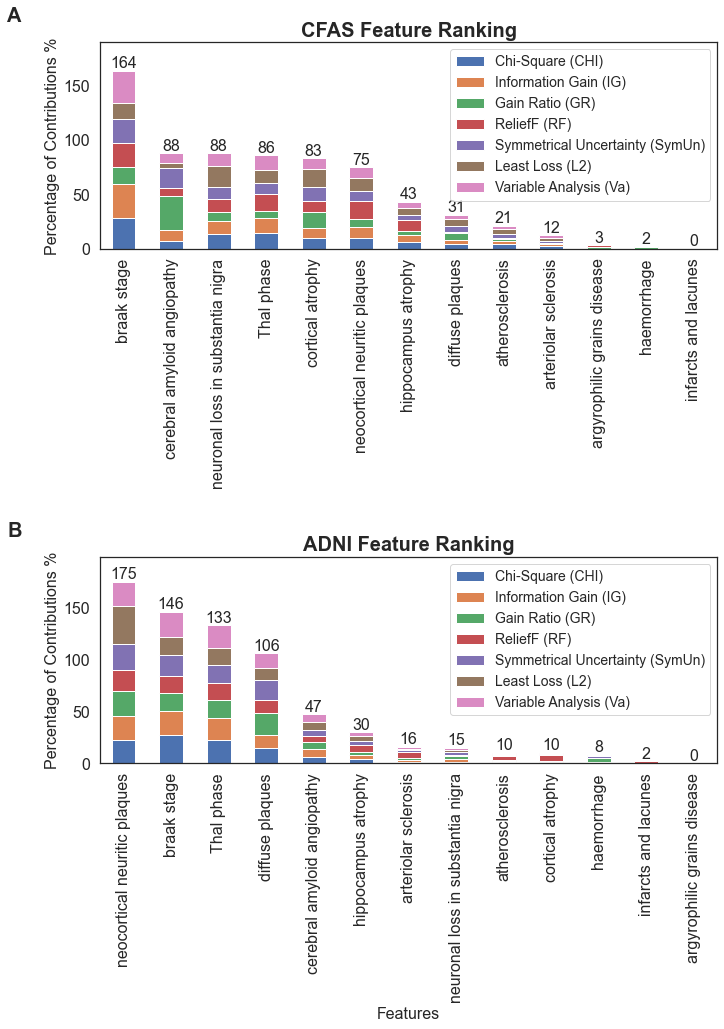

In [9]:
create_folder('Figures')
# sns.set_theme(style="ticks", color_codes=True)
# sns.color_palette()
sns.set_theme(style="white")
size = 16
plt.rc('font', size=size)          # controls default text sizes
plt.rc('axes', titlesize=size)     # fontsize of the axes title
plt.rc('axes', labelsize=size)    # fontsize of the x and y labels
plt.rc('ytick', labelsize=size)    # fontsize of the tick labels
plt.rc('legend', fontsize=size)    # legend fontsize
plt.rc('xtick', labelsize=size)    # fontsize of the tick labels

cfas_features_sum = cfas_features_percentage.Sum
adni_features_sum = adni_features_percentage.Sum

plt.rcParams['savefig.facecolor']='white'
# sns.set_theme(style="ticks", color_codes=True)


# fig, ax = plt.subplots(figsize=(12,12))
# fig, ax = plt.subplots(figsize=(12,12))
fig, ax = plt.subplots(2, 1, figsize=(10.25,14.8))

# ax = plt.subplot(2,1,1)
g=cfas_features_percentage.iloc[:,0:8].plot.bar(x='Features', stacked=True, ax=ax[0])
# cfas_features_sum = cfas_features_percentage.Sum
g.set_ylim(0, 190)

#add percentages above bars
rects = g.patches
for rect, label in zip(rects, cfas_features_sum):
    height = rect.get_height()
    g.text(rect.get_x() + rect.get_width()-0.25, label, "{}".format(int(label)), ha='center', va='bottom')

#add line for dropping features and add it to the legend
# g.axvline(x=15.5, color='r', linestyle='-.', label='Dropped Features-Right Side')
g.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
g.legend(['Chi-Square (CHI)',
           'Information Gain (IG)', 'Gain Ratio (GR)', 'ReliefF (RF)',
           'Symmetrical Uncertainty (SymUn)', 'Least Loss (L2)', 'Variable Analysis (Va)'], fontsize=14);

g.set_title('CFAS Feature Ranking', fontsize=20, fontweight='bold')
g.set_xlabel('')
g.set_ylabel('Percentage of Contributions %', fontsize=16)
# g.text(-0.15, 1.38, 'A:', transform=g.transAxes, size=20, weight='bold')
g.text(-0.15, 1.1, 'A', transform=g.transAxes, size=20, weight='bold')



gg=adni_features_percentage.iloc[:,0:8].plot.bar(x = 'Features', stacked=True, ax=ax[1])#, color=color)
# adni_features_sum = adni_features_percentage.Sum
gg.set_ylim(0, 199)

#add percentages above bars
rects = gg.patches
for rect, label in zip(rects, adni_features_sum):
    height = rect.get_height()
    gg.text(rect.get_x() + rect.get_width()-0.25, label, "{}".format(int(label)), ha='center', va='bottom')

#add line for dropping features and add it to the legend
# plt.axvline(x=13.5, color='r', linestyle='-.', label='Dropped Features-Right Side')
gg.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
gg.legend(['Chi-Square (CHI)',
           'Information Gain (IG)', 'Gain Ratio (GR)', 'ReliefF (RF)',
           'Symmetrical Uncertainty (SymUn)', 'Least Loss (L2)', 'Variable Analysis (Va)'], fontsize=14);
gg.set_title('ADNI Feature Ranking', fontsize=20, fontweight='bold')
gg.set_xlabel('Features', fontsize=16)
gg.set_ylabel('Percentage of Contributions %', fontsize=16)
# g.text(-0.15, 1.38, 'B:', transform=ax.transAxes, size=20, weight='bold')
gg.text(-0.15, 1.1, 'B', transform=gg.transAxes, size=20, weight='bold')

plt.tight_layout()



plt.savefig('Figures/both_Ranking.png', dpi=300, bbox_inches='tight')
plt.savefig('Figures/both_Ranking.pdf', dpi=300, bbox_inches='tight')


In [10]:
# load all filter methods scores obtained from weka
cfas_weka_results = pd.DataFrame(cfas_values).copy()
adni_weka_results = pd.DataFrame(adni_values).copy()

cfas_weka_results.to_csv(r'Ranking/cfas_weka_results_all.csv',mode = 'w',index=False)
adni_weka_results.to_csv(r'Ranking/adni_weka_results_all.csv',mode = 'w',index=False)



## Find Difference in Ranking Features

In [11]:
# load all filter methods scores obtained from weka
cfas_values = pd.read_csv(r'Ranking/cfas_values.csv',header = 0)
adni_values = pd.read_csv(r'Ranking/adni_values.csv',header = 0)

# raname columns
cfas_values.columns = ['Features', 'chi', 'gr', 'ig', 'rf', 'su', 'll', 'va']
adni_values.columns = ['Features', 'chi', 'gr', 'ig', 'rf', 'su', 'll', 'va']


def ranking_results(data):
    df = pd.DataFrame()
    for method in ['chi', 'gr', 'ig', 'rf', 'su', 'll', 'va']:
        exec("%s"%method+" = pd.DataFrame()")
        exec("%s"%method+"= data[['Features', '%s"%method+"']]")
        exec("%s"%method+".sort_values(by='%s"%method+"', ascending=False, inplace=True)")
        exec("%s"%method+".reset_index(drop=True, inplace=True)")
        exec("df[['F_%s"%method+"', '%s"%method+"']] = %s"%method+"[['Features', '%s"%method+"']]")

    return df

# call function to add feature columns for each method and sort them
cfas_v = ranking_results(cfas_values)
adni_v = ranking_results(adni_values)

In [12]:
# function to find the difference with two parameters [first, second] first is the main parameter
# where this difference in ranking is based on

def find_difference(a_data, a, b_data, b, method):
    sum_ = pd.DataFrame()
    sum_[[a]] = a_data[['F_%s'%method]]
    # adni_cfas_sum.index = adni_cfas_sum.index + 1
    sum_['%s_index'%a] = sum_.index

    sum_[[b]] = b_data[['F_%s'%method]]
    sum_['%s_index'%b] = b_data.index


    sum_.index = sum_.index + 1
    sum_['%s_index'%b] = sum_.index
    sum_['%s_index'%a] = sum_.index

    b_compare = list()
    for each in sum_[a]:
        for index, row in sum_.iterrows():
            if(row[b] == each):
                b_compare.append(row['%s_index'%b])
                break;

    # cfas_compare
    a_compare = sum_['%s_index'%a].to_list()

    # ordered_df = adni_cfas_sum.CFAS.sort_values(by='ADNI')
    my_range=range(len(sum_.index)+1, 1, -1)
    my_range
    
    return sum_, a_compare, b_compare, my_range

## Consistency between Filter Methods (kendalltau)

In [13]:
import scipy.stats as stats

tau_p_value = pd.DataFrame(columns=['Ranking Method', 'tau', 'p-value'])

tau, p_value = stats.kendalltau(cfas_v.F_chi, adni_v.F_chi)
new_row = {'Ranking Method':'Chi-Square', 'tau':tau, 'p-value':p_value}
tau_p_value = tau_p_value.append(new_row, ignore_index=True)

tau, p_value = stats.kendalltau(cfas_v.F_gr, adni_v.F_gr)
new_row = {'Ranking Method':'Gain Ratio', 'tau':tau, 'p-value':p_value}
tau_p_value = tau_p_value.append(new_row, ignore_index=True)

tau, p_value = stats.kendalltau(cfas_v.F_ig, adni_v.F_ig)
new_row = {'Ranking Method':'Information Gain', 'tau':tau, 'p-value':p_value}
tau_p_value = tau_p_value.append(new_row, ignore_index=True)

tau, p_value = stats.kendalltau(cfas_v.F_rf, adni_v.F_rf)
new_row = {'Ranking Method':'ReliefF', 'tau':tau, 'p-value':p_value}
tau_p_value = tau_p_value.append(new_row, ignore_index=True)

tau, p_value = stats.kendalltau(cfas_v.F_su, adni_v.F_su)
new_row = {'Ranking Method':'Symmetrical Uncertainty', 'tau':tau, 'p-value':p_value}
tau_p_value = tau_p_value.append(new_row, ignore_index=True)

tau, p_value = stats.kendalltau(cfas_v.F_ll, adni_v.F_ll)
new_row = {'Ranking Method':'Least Loss', 'tau':tau, 'p-value':p_value}
tau_p_value = tau_p_value.append(new_row, ignore_index=True)

tau, p_value = stats.kendalltau(cfas_v.F_va, adni_v.F_va)
new_row = {'Ranking Method':'Variable Analysis', 'tau':tau, 'p-value':p_value}
tau_p_value = tau_p_value.append(new_row, ignore_index=True)


tau_p_value.sort_values(by=['tau'], ascending=False, inplace=True)
tau_p_value = tau_p_value[['Ranking Method', 'tau']] 

## Plot difference & Consistency

Directory [ Figures ] already exists


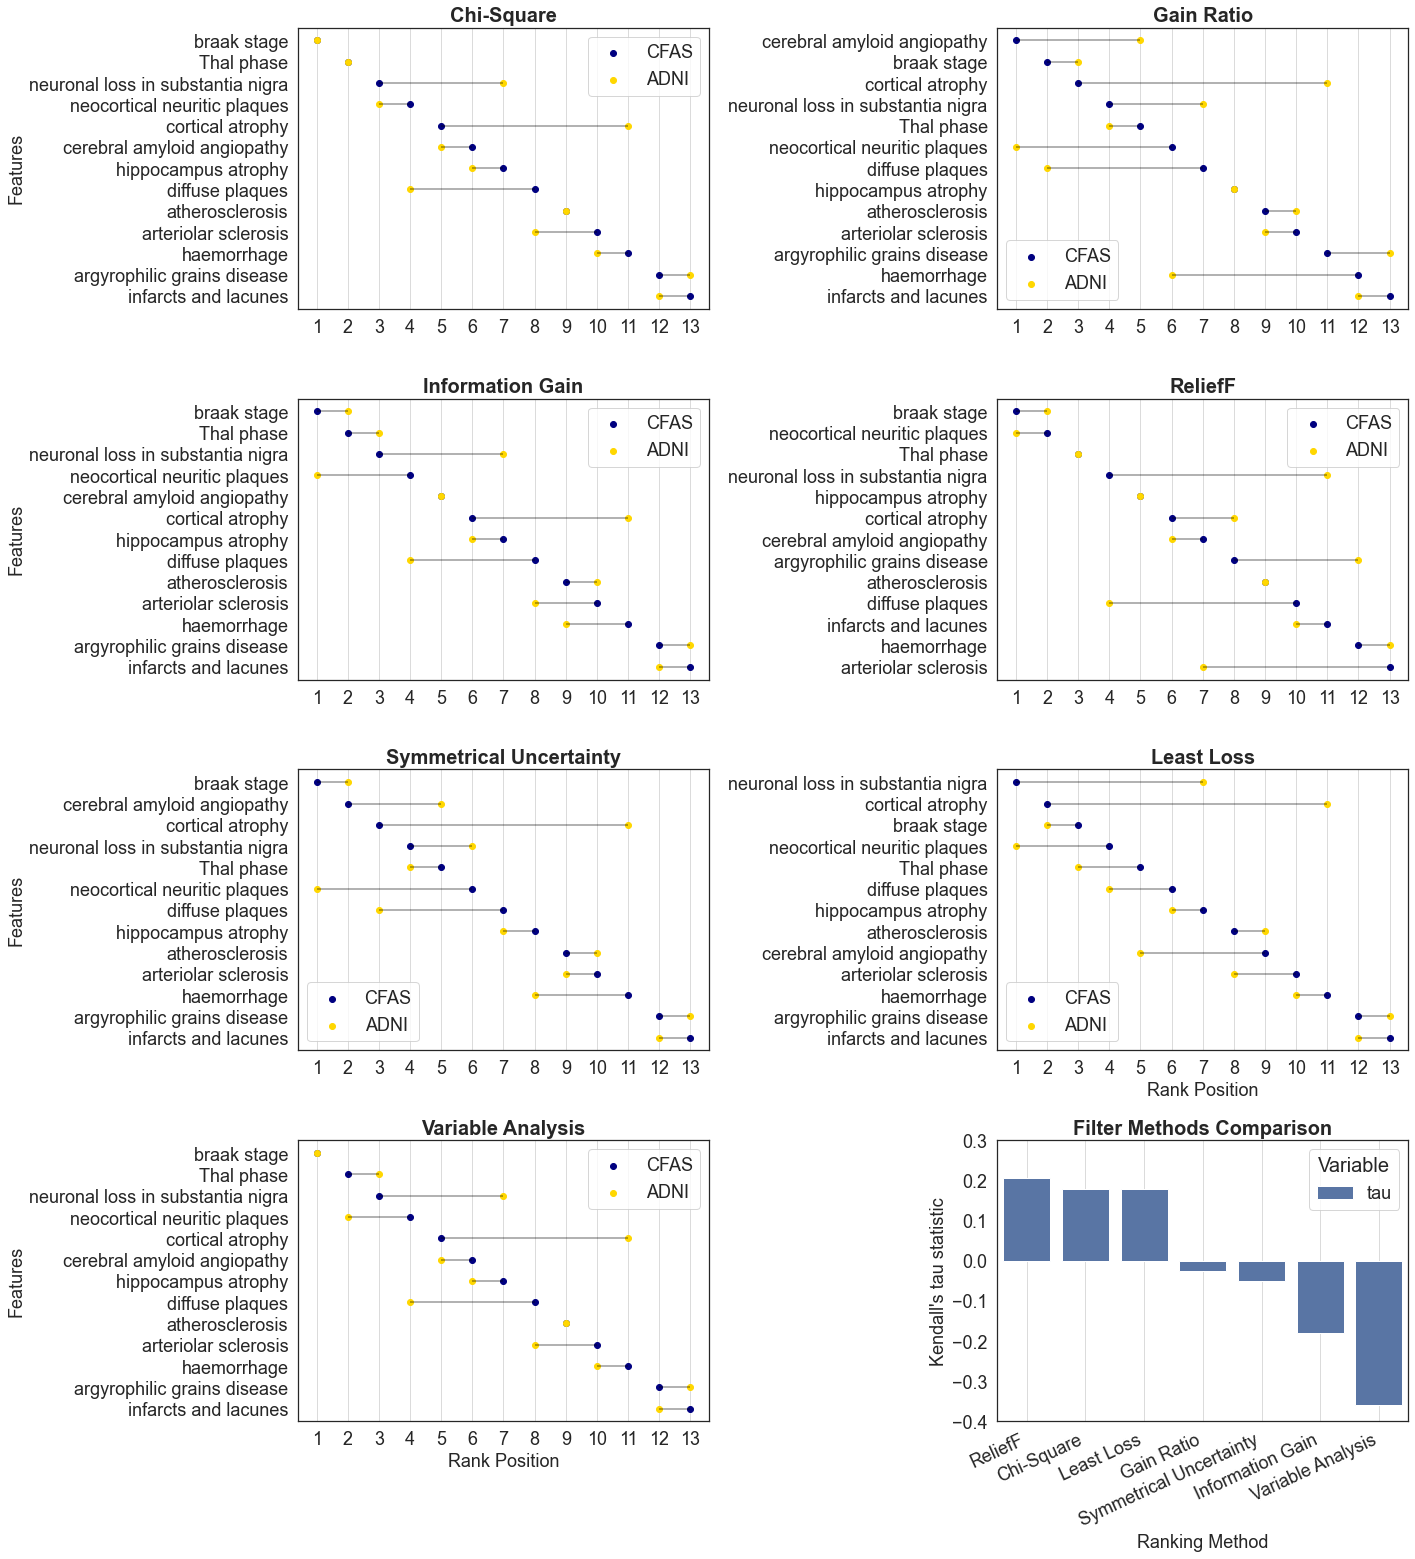

In [14]:
create_folder('Figures')
sns.set_theme(style="white")
# sns.set_theme(style="ticks", color_codes=True)
size = 18
plt.rc('font', size=size)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=size)    # fontsize of the x and y labels
plt.rc('ytick', labelsize=size)    # fontsize of the tick labels
plt.rc('legend', fontsize=size)    # legend fontsize
plt.rc('xtick', labelsize=size)    # fontsize of the tick labels

# plt.subplots_adjust(wspace=1.5)
# fig= plt.figure(figsize=(20,20))
fig, ax = plt.subplots(figsize=(20,22))

ax = plt.subplot(4,2,1)
sum_, cfas_compare, adni_compare, my_range = find_difference(cfas_v[['F_chi', 'chi']],'CFAS', adni_v[['F_chi', 'chi']], 'ADNI', 'chi')
plt.hlines(y=my_range, xmin=cfas_compare, xmax=adni_compare, color='black', alpha=0.4)
plt.scatter(cfas_compare, my_range, color='navy', alpha=1, label='CFAS')
plt.scatter(adni_compare, my_range, color='gold', alpha=1, label='ADNI')
plt.yticks(my_range, sum_['CFAS'])
plt.xticks(np.arange(1, 14, 1))
plt.legend()
plt.title('Chi-Square', fontsize=20, fontweight='bold')
# plt.xlabel('Rank')
plt.ylabel('Features')
plt.grid(axis='x', linewidth=.7)
plt.tight_layout()


ax = plt.subplot(4,2,2)
sum_, cfas_compare, adni_compare, my_range = find_difference(cfas_v[['F_gr', 'gr']],'CFAS', adni_v[['F_gr', 'gr']], 'ADNI', 'gr')
plt.hlines(y=my_range, xmin=cfas_compare, xmax=adni_compare, color='black', alpha=0.4)
plt.scatter(cfas_compare, my_range, color='navy', alpha=1, label='CFAS')
plt.scatter(adni_compare, my_range, color='gold', alpha=1, label='ADNI')
plt.yticks(my_range, sum_['CFAS'])
plt.xticks(np.arange(1, 14, 1))
plt.legend()
plt.title('Gain Ratio', fontsize=20, fontweight='bold')
# plt.xlabel('Rank')
# plt.ylabel('Features Rank (based on CFAS_R-squared ranking)')
plt.grid(axis='x', linewidth=.7)
plt.tight_layout()

ax = plt.subplot(4,2,3)
sum_, cfas_compare, adni_compare, my_range = find_difference(cfas_v[['F_ig', 'ig']],'CFAS', adni_v[['F_ig', 'ig']], 'ADNI', 'ig')
plt.hlines(y=my_range, xmin=cfas_compare, xmax=adni_compare, color='black', alpha=0.4)
plt.scatter(cfas_compare, my_range, color='navy', alpha=1, label='CFAS')
plt.scatter(adni_compare, my_range, color='gold', alpha=1, label='ADNI')
plt.yticks(my_range, sum_['CFAS'])
plt.xticks(np.arange(1, 14, 1))
plt.legend()
plt.title('Information Gain', fontsize=20, fontweight='bold')
# plt.xlabel('Rank')
plt.ylabel('Features')
plt.grid(axis='x', linewidth=.7)
plt.tight_layout()

ax = plt.subplot(4,2,4)
sum_, cfas_compare, adni_compare, my_range = find_difference(cfas_v[['F_rf', 'rf']],'CFAS', adni_v[['F_rf', 'rf']], 'ADNI', 'rf')
plt.hlines(y=my_range, xmin=cfas_compare, xmax=adni_compare, color='black', alpha=0.4)
plt.scatter(cfas_compare, my_range, color='navy', alpha=1, label='CFAS')
plt.scatter(adni_compare, my_range, color='gold', alpha=1, label='ADNI')
plt.yticks(my_range, sum_['CFAS'])
plt.xticks(np.arange(1, 14, 1))
plt.legend()
plt.title('ReliefF', fontsize=20, fontweight='bold')
# plt.xlabel('Rank')
# plt.ylabel('Features Rank (based on CFAS_R-squared ranking)')
plt.grid(axis='x', linewidth=.7)
plt.tight_layout()

ax = plt.subplot(4,2,5)
sum_, cfas_compare, adni_compare, my_range = find_difference(cfas_v[['F_su', 'su']],'CFAS', adni_v[['F_su', 'su']], 'ADNI', 'su')
plt.hlines(y=my_range, xmin=cfas_compare, xmax=adni_compare, color='black', alpha=0.4)
plt.scatter(cfas_compare, my_range, color='navy', alpha=1, label='CFAS')
plt.scatter(adni_compare, my_range, color='gold', alpha=1, label='ADNI')
plt.yticks(my_range, sum_['CFAS'])
plt.xticks(np.arange(1, 14, 1))
plt.legend()
plt.title('Symmetrical Uncertainty', fontsize=20, fontweight='bold')
# plt.xlabel('Rank')
plt.ylabel('Features')
plt.grid(axis='x', linewidth=.7)
plt.tight_layout()

ax = plt.subplot(4,2,6)
sum_, cfas_compare, adni_compare, my_range = find_difference(cfas_v[['F_ll', 'll']],'CFAS', adni_v[['F_ll', 'll']], 'ADNI', 'll')
plt.hlines(y=my_range, xmin=cfas_compare, xmax=adni_compare, color='black', alpha=0.4)
plt.scatter(cfas_compare, my_range, color='navy', alpha=1, label='CFAS')
plt.scatter(adni_compare, my_range, color='gold', alpha=1, label='ADNI')
plt.yticks(my_range, sum_['CFAS'])
plt.xticks(np.arange(1, 14, 1))
plt.legend()
plt.title('Least Loss', fontsize=20, fontweight='bold')
plt.xlabel('Rank Position')
# plt.ylabel('Features Rank (based on CFAS_R-squared ranking)')
plt.grid(axis='x', linewidth=.7)
plt.tight_layout()

ax = plt.subplot(4,2,7)
sum_, cfas_compare, adni_compare, my_range = find_difference(cfas_v[['F_va', 'va']],'CFAS', adni_v[['F_va', 'va']], 'ADNI', 'va')
plt.hlines(y=my_range, xmin=cfas_compare, xmax=adni_compare, color='black', alpha=0.4)
plt.scatter(cfas_compare, my_range, color='navy', alpha=1, label='CFAS')
plt.scatter(adni_compare, my_range, color='gold', alpha=1, label='ADNI')
plt.yticks(my_range, sum_['CFAS'])
plt.xticks(np.arange(1, 14, 1))
plt.legend()
plt.title('Variable Analysis', fontsize=20, fontweight='bold')
plt.xlabel('Rank Position')
plt.ylabel('Features')
plt.grid(axis='x', linewidth=.7)
plt.tight_layout()

ax = plt.subplot(4,2,8)
tidy = tau_p_value.melt(id_vars='Ranking Method').rename(columns=str.title)
ax = sns.barplot(x='Ranking Method', y='Value', hue='Variable', data=tidy)
plt.xticks(rotation=25, ha='right')
plt.setp(ax.get_legend().get_title(), fontsize='20') 
# plt.xlabel('Rank Position')
plt.ylabel("Kendall's tau statistic")
plt.ylim(-0.4,0.3,0.05)
plt.title("Filter Methods Comparison", fontsize=20, fontweight='bold')
plt.grid(axis='x', linewidth=.7)
plt.tight_layout()


plt.savefig('Figures/difference_in_rank.png', dpi=300, bbox_inches='tight')
plt.savefig('Figures/difference_in_rank.pdf', dpi=300, bbox_inches='tight')
